Kalman Filter, Gerrik
Load the data

As can be seen above, both files contain the same variables.

In [ ]:
from scipy.optimize import minimize
import numpy as NP
import pandas as PD
import os, pickle
import matplotlib.pyplot as PLT
import Neural_Decoding as ND
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.decoders import KalmanFilterDecoder
import sklearn
from matplotlib import pyplot as PLT

training_range=[0, 0.5]
valid_range=[0.5,0.65]
Testing_range=[0.65, 0.8]
lag=0

def Load_file_and_preprocess(File_Name=""):
    File=open("C:/Users/gerri/Coding_Folder/Data_Folder/DS_Final_Data/example_data_hc.pickle",mode='rb')
    [neural_data,pos_binned]=pickle.load(File,)
    print(f"neural_data \n{NP.shape(neural_data)}"+"\n"+f"pos_binned \n{NP.shape(pos_binned)}")

    """
    neural_data:    When neurons Fired. num_bins x num_neurons. 1 when fired, 0 when not.
    pos_binned       :    X and Y velocities

    rows pos and neural data are equal.
    """

    #Remove all rows of pos X and Y where pos_binned is NaN
    Rmv_Indx=NP.where(NP.isnan(pos_binned[:,0]))
    X=NP.delete(neural_data,Rmv_Indx,0)
    Y=NP.delete(pos_binned,Rmv_Indx,0)
    
    
    vels=NP.diff(Y,axis=0) #x and y velocities. Diff between rows.
    accels=NP.diff(vels,axis=0) #Determine acceleration

    #Y is the positions binned, velocities binned, then acc_binned in numpy array.
    #Remove first and 2nd row of X and Y because lost information loss from getting velocity and accel of data.
    #Remove first row of vel because lost information from calculating acceleration.
    Rmv_Indx=[0,1]
    X=NP.delete(X,Rmv_Indx,0)
    Y=NP.delete(Y,Rmv_Indx,0)
    vels=NP.delete(vels,0,0)
    Y=NP.concatenate((Y,vels,accels),axis=1)
    
    
    
    return X,Y
X,Y=Load_file_and_preprocess()
#Center Y along axis=0
# Y_mean=NP.mean(Y,axis=0)
# Y=(Y-Y_mean)/Y_std

def Standardize_Data(Data:NP.ndarray):
    if type(Data)!=NP.ndarray:
        NP.ndarray(Data)
    nd_mean=NP.mean(Data,axis=0)
    nd_std=NP.std(Data,axis=0)
    Data=(Data-nd_mean)/nd_std
    return Data

X=Standardize_Data(X)



neural_data 
(28039, 58)
pos_binned 
(28039, 2)
[3.84173488e-03 1.07712193e-04 5.63693810e-03 1.07712193e-04
 5.38560965e-04 1.50797070e-03 1.82751687e-02 3.59040643e-04
 4.52391211e-03 7.18081287e-04 1.78802240e-02 1.40025851e-03
 4.66752836e-04 3.76992676e-03 2.40916272e-02 8.82521901e-02
 8.61697544e-04 5.49332184e-03 1.99267557e-02 8.61697544e-04
 7.19158409e-02 5.61539566e-02 2.08243573e-03 3.62631050e-03
 6.26884963e-02 5.69438460e-02 6.03906362e-02 1.86413902e-01
 1.75570875e-02 4.04997846e-02 1.36794485e-02 2.90104840e-02
 2.95490450e-02 1.35250610e-01 2.11449806e+00 4.50596007e-02
 9.33146632e-02 2.13234238e-01 3.66221456e-02 1.29254632e-02
 2.79082292e-01 2.13341950e-01 6.92948442e-03 1.88137297e-02
 3.33907798e-03 1.11266695e-01 9.71923022e-02 7.46086457e-02
 2.92259084e-02 5.02297860e-02 7.36392360e-02 3.54854229e+00
 6.64225190e-03 2.10720954e-01 4.29771650e-02 3.16562545e+00
 3.76389487e+00 2.58509263e-02]


In [ ]:
def Gerrik_Kalman_Model(X,Y):
    C=NP.size(X,1)  # Number of neurons
    Coefficient_Matrix=NP.ones((C*C,1)) #C x C
    X=np.matrix(Y.T) #X is now 6 x num_timepoints. It is the observation matrix
    Priori_X=X[:-2,:].reshape(-1,1)  # Initial state estimate
    Posteriori_X=X[1:,:].reshape(-1,1)  # Initial state estimate
    State_Relation=NP.eye(C)  # State transition matrix
    # X is the neural firing data
    # Y is the position, velocity, acceleration data
    # Define the Kalman Filter parameters
    def objective(A, X, B):
        """
        X-AB
        Calculate difference between time points, t and t+1
        Calculate the error between X and BA.
        A: vector to optimize (flattened)
        X: target vector (1xn) where it is B at the next time point
        B: prior time point of X (mxm)
        Returns: scalar error value to minimize
        """
        A_reshaped = A.reshape(-1, 1)  # Convert back to mx1
        error = X - B @ A_reshaped
        return NP.sum(error ** 2)  # Sum of squared errors


    Result_A,final_error_A, converged_A= minimize(
    fun=objective,
    x0=Coefficient_Matrix,
    args=(Posteriori_X, Priori_X),
    method='BFGS',  # Good for smooth, nonlinear problems
    options={'maxiter': 1000}# Tighter tolerance for accuracy
    )
        
    print(f"A matrix:\n{Result_A}")
    print(f"Final error: {final_error_A}")
    print(f"Converged: {converged_A}")
    
    Result_H,final_error_H, converged_H = minimize(
    fun=objective,
    x0=State_Relation.flatten(),
    args=(Y, X),
    method='BFGS',  # Good for smooth, nonlinear problems
    options={'maxiter': 1000}# Tighter tolerance for accuracy
    )
        
    print(f"A matrix:\n{Result_H}")
    print(f"Final error: {final_error_H}")
    print(f"Converged: {converged_H}")
        


R2: [0.00936326 0.09058783]
rho2: [0.0177395  0.12798751]


C:\Users\gerri\AppData\Local\Temp\ipykernel_25348\1047749910.py:8: RuntimeWarning: invalid value encountered in divide
  X_Train=(X_Train-X_Train_mean)/X_Train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_25348\1047749910.py:9: RuntimeWarning: divide by zero encountered in divide
  X_Test=(X_Test-X_Train_mean)/X_Train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_25348\1047749910.py:9: RuntimeWarning: invalid value encountered in divide
  X_Test=(X_Test-X_Train_mean)/X_Train_std
C:\Users\gerri\AppData\Local\Temp\ipykernel_25348\1047749910.py:10: RuntimeWarning: invalid value encountered in divide
  X_Valid=(X_Valid-X_Train_mean)/X_Train_std


R2: [nan nan]
rho2: [nan nan]


C:\Users\gerri\AppData\Local\Temp\ipykernel_25348\1047749910.py:10: RuntimeWarning: divide by zero encountered in divide
  X_Valid=(X_Valid-X_Train_mean)/X_Train_std


R2: [nan nan]
rho2: [nan nan]


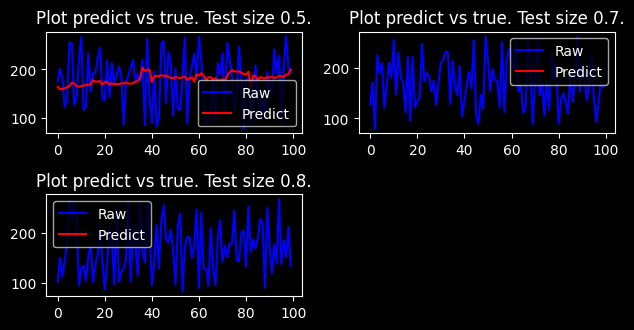

In [ ]:
for IDX,Test_Size in enumerate([0.5,0.7,0.8]):
    X_Train, X_Test, Y_Train, Y_Test =sklearn.model_selection.train_test_split(X,Y,test_size=Test_Size)
    X_Valid, X_Test, Y_Valid, Y_Test =sklearn.model_selection.train_test_split(X_Test,Y_Test,test_size=Test_Size)
    
    #Declare model
    Model=KalmanFilterDecoder(C=5) #There is one optional parameter (see ReadMe)

    #Fit model, there is some bug where it keeps saying there is a singula matrix, which I think is because of how the populations are divided. The error IS based on the random state.
    Model.fit(X_Train,Y_Train)

    #Get predictions
    Y_Valid_predicted=Model.predict(X_Valid,Y_Valid)
    

    #Get metrics of fit (see read me for more details on the differences between metrics)
    #First I'll get the R^2
    R2=get_R2(Y_Valid,Y_Valid_predicted)
    print('R2:',R2[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
    #Next I'll get the rho^2 (the pearson correlation squared)
    rho=get_rho(Y_Valid,Y_Valid_predicted)
    print('rho2:',rho[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions
    
    PLT.subplot(3,2,IDX+1)
    PLT.plot(Y_Valid[2000:2100,0]+Y_Train_mean[0],'b',label="Raw")
    PLT.plot(Y_Valid_predicted[2000:2100,0]+Y_Train_mean[0],'r',label="Predict")
    PLT.title(f"Plot predict vs true. Test size {Test_Size}.")
    PLT.legend()
PLT.tight_layout()
PLT.savefig('Kalman.png')

In [ ]:
from numpy.linalg import inv as inv #Used in kalman filter

def Gerrik_Kalman_Fit(self,X_train,Y_train,X_Test,y_Test):
    C=1
    """
    Train Kalman Filter Decoder

    Parameters
    ----------
    X_train: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
        This is the neural data in Kalman filter format.
        See example file for an example of how to format the neural data correctly

    y_train: numpy 2d array of shape [n_samples(i.e. timebins), n_outputs]
        This is the outputs that are being predicted
        
    Predict outcomes using trained Kalman Filter Decoder

    X_Test: numpy 2d array of shape [n_samples(i.e. timebins) , n_neurons]
        This is the neural data in Kalman filter format.

    y_Test: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
        The actual outputs
        This parameter is necesary for the Kalman filter (unlike other decoders)
        because the first value is nececessary for initialization

    Returns
    -------
    y_Test_predicted: numpy 2d array of shape [n_samples(i.e. timebins),n_outputs]
        The predicted outputs
    """

    #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al, 2003):
    #xs are the state (here, the variable we're predicting, i.e. y_train)
    #zs are the observed variable (neural data here, i.e. X_train)
    
    #.T means transpose for numpy arrays.
    X=NP.matrix(Y_train.T)
    Z=NP.matrix(X_train.T)

    #number of time bins
    nt=X.shape[1]

    #Calculate the transition matrix (from x_t to x_t+1) using least-squares, and compute its covariance
    #In our case, this is the transition from one kinematic state to the next
    X2 = X[:,1:]
    X1 = X[:,0:-2]
    A=X2*X1.T*inv(X1*X1.T) #Transition matrix
    W=(X2-A*X1)*(X2-A*X1).T/(nt-1)/C#Covariance of transition matrix. Note we divide by nt-1 since only nt-1 points were used in the computation (that's the length of X1 and X2). We also introduce the extra parameter C here.

    #Calculate the measurement matrix (from x_t to z_t) using least-squares, and compute its covariance
    #In our case, this is the transformation from kinematics to spikes
    H = Z*X.T*(inv(X*X.T)) #Measurement matrix
    Q = ((Z - H*X)*((Z - H*X).T)) / nt #Covariance of measurement matrix
    self.params=[A,W,H,Q]

    #First we'll rename and reformat the variables to be in a more standard kalman filter nomenclature (specifically that from Wu et al):
    #xs are the state (here, the variable we're predicting, i.e. y_train)
    #zs are the observed variable (neural data here, i.e. X_Train)
    X=NP.matrix(y_test.T)
    Z=NP.matrix(X_Test.T)

    #Initializations
    num_states=X.shape[0] #Dimensionality of the state
    P_m=NP.matrix(NP.zeros([num_states,num_states]))
    P=NP.matrix(NP.zeros([num_states,num_states]))
    state=X[:,0] #Initial state
    Y_test_predicted=NP.copy(NP.squeeze(state))

    #Get predicted state for every time bin
    for t in range(X.shape[1]-1):
        #Do first part of state update - based on transition matrix
        P_m=A*P*A.T+W   #W
        state_m=A*state

        #Do second part of state update - based on measurement matrix
        K=P_m*H.T*inv(H*P_m*H.T+Q) #Calculate Kalman gain
        P=(NP.matrix(NP.eye(num_states))-K*H)*P_m
        state=state_m+K*(Z[:,t+1]-H*state_m)
        Y_test_predicted[:,t+1]=NP.squeeze(state) #Record state at the timestep
    Y_test_predicted=states.T
    return y_test_predicted,

NameError: name 'X_kf' is not defined